<a href="https://colab.research.google.com/github/rutasnim/Stackoverflow_Bigquery_EDA/blob/main/Stackoverflow_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis on Stackoverflow posts with BigQuery
In this project, I explored  stackoverflow posts dataset on BigQuery. I explored the structure and also discovered the following:

1.   the popular topics on stackoverflow by lifetime and also by years
2.   
the top topics that were asked by lifetime and by years
3. The most difficult topics
4. Does using the word "help" in stackoverflow post will help get answers?






### Authenticate 




In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


### **Importing libraries**

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns


### Dataset

In [9]:
%%bigquery --project t-bounty-355119
SELECT 
    *
  FROM `bigquery-public-data.stackoverflow.stackoverflow_posts`
LIMIT 5

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count
0,525063,Android Respond To URL in Intent,<p>I want my intent to be launched when the us...,525086,1,2,None,2009-02-08 02:55:56.867000+00:00,65,2016-04-10 03:28:09.653000+00:00,2015-08-15 10:24:12.720000+00:00,None,1529129.0,Isaac Waller,764272.0,None,1,132,android|url|android-intent|intentfilter|launch,91060
1,14128723,Eclipse -- Progress windows don't show up any ...,<p>I used to see both Building and Cleaning ac...,14128762,1,0,None,2013-01-02 20:31:53.523000+00:00,4,2013-01-02 20:34:55.003000+00:00,NaT,None,NaN,user1499731,NaN,None,1,13,java|eclipse,4272
2,20728,What's the best way to create ClickOnce deploy...,<p>Our team develops distributed winform apps....,20806,2,0,None,2008-08-21 18:35:04.410000+00:00,5,2015-11-30 02:03:49.403000+00:00,2015-11-30 02:03:49.403000+00:00,None,1321.0,whatknott,1321.0,None,1,13,winforms|deployment|clickonce,2534
3,6531409,iOS: how to get image dimensions without openi...,<p>In an iOS app I need to provide image filte...,8731972,2,2,None,2011-06-30 07:33:38.647000+00:00,4,2014-04-22 17:16:44.230000+00:00,2012-01-24 07:37:04.003000+00:00,user83950,NaN,user83950,NaN,None,1,7,ios4|uikit,2837
4,593205,action delegate with zero parameters,<p>I see this line in many online examples of ...,593223,2,3,None,2009-02-27 01:30:27.723000+00:00,6,2012-01-12 01:44:40.020000+00:00,2012-01-12 01:44:40.020000+00:00,None,8677.0,I. J. Kennedy,8677.0,None,1,21,c#|delegates|action,12377


#### Total rows 

In [ ]:
%%bigquery --project t-bounty-355119
SELECT 
    COUNT(*)/1000000 as total_row_million
  FROM `bigquery-public-data.stackoverflow.stackoverflow_posts`




,total_row_million
0,31.017889


This dataset contains ~31 million rows!

## Structure ingestion

# Analysis

## Most popular Tags by lifetime





> Lets find out the top 10 tags that has the most views. 





In [11]:
%%bigquery --project t-bounty-355119 df
SELECT tag tags, sum(view_count)/1000000 total_views_in_millions
FROM 
(SELECT SPLIT(tags, '|') tags, view_count
FROM `bigquery-public-data.stackoverflow.stackoverflow_posts`), 
UNNEST(tags) tag
GROUP by 1
order by 2 DESC
LIMIT 11


In [12]:
df

,tags,total_views_in_millions
0,java,2083.780431
1,javascript,1882.931036
2,c#,1756.321167
3,android,1445.802569
4,jquery,1317.528401
5,php,1154.290455
6,html,973.968703
7,python,927.116555
8,css,800.594918
9,c++,669.425261


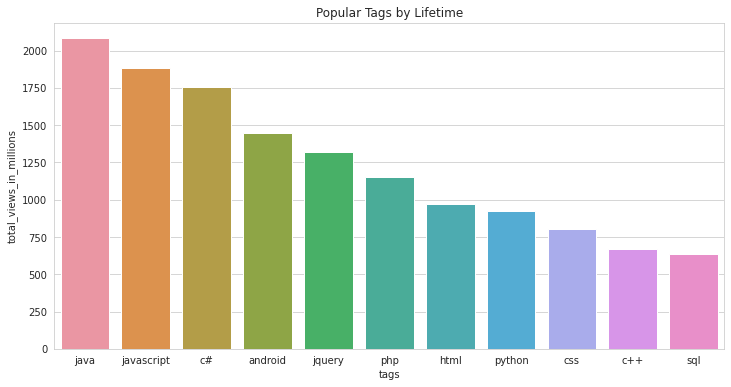

In [13]:
sns.set_style("whitegrid")
f = plt.figure(figsize=(12, 6))
f=plt.title("Popular Tags by Lifetime")
ax = sns.barplot(x="tags", y="total_views_in_millions", data=df)

### Most popular tags by years


> Now I want to find the top 5 viewed tags for every year



In [14]:
%%bigquery --project t-bounty-355119 df
WITH year_tagged as 
(SELECT a.year, a.view_count, tag 
FROM
(SELECT EXTRACT(YEAR from creation_date) year, SPLIT(tags, '|') tags, view_count 
FROM `bigquery-public-data.stackoverflow.stackoverflow_posts`) a, 
UNNEST(tags) tag)
SELECT b.* FROM
(SELECT year, tag, total_views,
Rank() over(partition by year order by total_views DESC) as rnk
FROM (SELECT year, tag, sum(view_count) total_views
FROM year_tagged
GROUP BY year, tag)) b
WHERE b.rnk<6
ORDER by 1, rnk

LIMIT 10000

In [15]:
df

,year,tag,total_views,rnk
0,2008,c#,123909672,1
1,2008,javascript,106854671,2
2,2008,java,106408501,3
3,2008,.net,73271516,4
4,2008,python,66025358,5
5,2009,c#,312810157,1
6,2009,java,266026459,2
7,2009,javascript,262291378,3
8,2009,jquery,185502026,4
9,2009,python,147365839,5


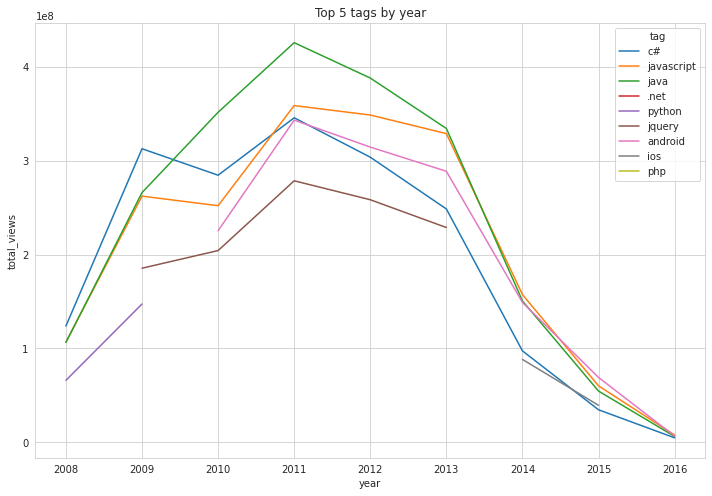

In [17]:
sns.set_style("whitegrid")
f = plt.figure(figsize=(12, 8))
f=plt.title("Top 5 tags by year")
sns.lineplot(x="year", y="total_views", hue="tag", data=df)

## Most asked tags 

In [ ]:
%%bigquery --project t-bounty-355119
SELECT tag, count(id) questions
FROM 
(SELECT SPLIT(tags, '|') tags, id
FROM `bigquery-public-data.stackoverflow.stackoverflow_posts`), 
UNNEST(tags) tag
-- WHERE tag is not null
GROUP by 1
having tag is not NULL
-- HAVING count(id) !=19171371
order by 2 DESC

LIMIT 11



,tag,questions
0,,19171371
1,javascript,1143864
2,java,1086506
3,c#,962755
4,php,933606
5,android,848769
6,jquery,744879
7,python,587679
8,html,545002
9,c++,452908


## Unanswered vs answered questions- Difficult topics



> Lets look at the topics with the most unanswered posts. 




In [28]:
%%bigquery --project t-bounty-355119 df
select tag, 
       sum(if(answer_count = 0, 1, 0)) as not_answered,
       sum(if(answer_count > 0, 1, 0)) as answered,
       count(*) as total, 
       sum(if(answer_count = 0, 1, 0))*100/ count(*) as percent_not_answered
from (
  select tag, answer_count
  from (
    select split(tags, '|') as tags, answer_count
    from `bigquery-public-data.stackoverflow.posts_questions`
  ),
  unnest(tags) tag
)
group by tag
order by not_answered desc
limit 20

In [29]:
df

,tag,not_answered,answered,total,percent_not_answered
0,javascript,324420,2019154,2343574,13.842960
1,python,295541,1606575,1902116,15.537486
2,java,255991,1574885,1830876,13.981886
3,android,234920,1131691,1366611,17.189968
4,c#,195649,1329799,1525448,12.825675
5,php,181773,1248075,1429848,12.712750
6,html,125702,991127,1116829,11.255259
7,jquery,107546,916212,1023758,10.505022
8,ios,104842,562735,667577,15.704855
9,c++,92993,663478,756471,12.293003


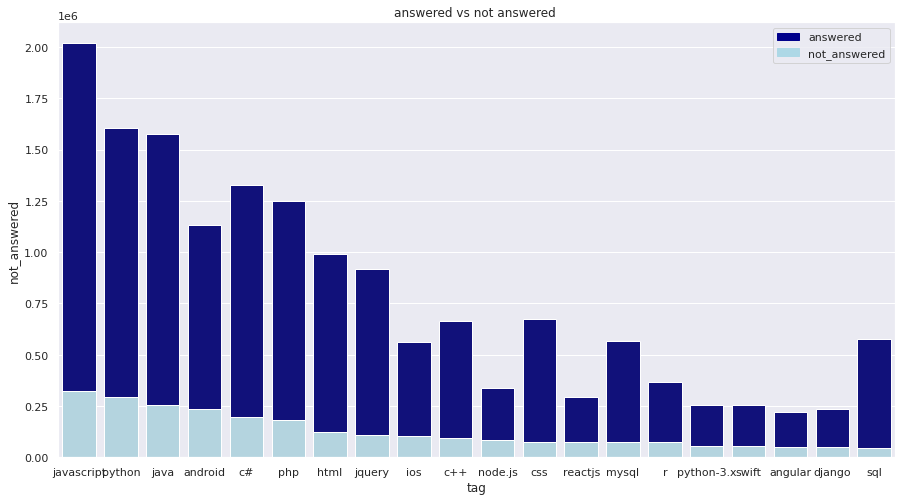

In [42]:
sns.set(style="darkgrid")
plt.figure(figsize=(15, 8))
plt.title("Answered vs not answered tags")

bar1 = sns.barplot(x="tag",  y="answered", data=df, color='darkblue')
bar2 = sns.barplot(x="tag",  y="not_answered", data=df, color='lightblue')



#legend
top_bar =  mpatches.Patch(color='darkblue', label='answered')
bottom_bar =mpatches.Patch(color='lightblue', label='not_answered')
plt.legend(handles=[top_bar, bottom_bar])

plt.show()

### Stackoverflow posts with accepted answer: Did they contain **help** word in the post?

In [ ]:
%%bigquery --project t-bounty-355119
SELECT count(case when body like '%help%' then 1 end)*100/count(*) percent_post_with_help
FROM `bigquery-public-data.stackoverflow.stackoverflow_posts`



,percent_post_with_help
0,11.275355


~ 11.3% of the post contains the word "***help***" 


### Does using the word "***help***" in stackoverflow post will help get answers?







In [6]:
%%bigquery --project t-bounty-355119 df
SELECT Extract(Year from creation_date) year, 
IF(body like'%help%', 'contains help','does not contain help') as contains_help,
ROUND(count(accepted_answer_id)*100/ count(*), 2)  as answered,
ROUND(AVG(answer_count),2) avg_answers
FROM `bigquery-public-data.stackoverflow.stackoverflow_posts`
GROUP BY 1,2
ORDER BY 1,2

In [7]:
df

,year,contains_help,answered,avg_answers
0,2008,contains help,18.22,5.02
1,2008,does not contain help,15.69,5.28
2,2009,contains help,25.89,3.01
3,2009,does not contain help,18.72,3.30
4,2010,contains help,32.87,2.20
5,2010,does not contain help,21.74,2.43
6,2011,contains help,34.59,1.91
7,2011,does not contain help,22.12,2.06
8,2012,contains help,34.77,1.68
9,2012,does not contain help,21.94,1.78


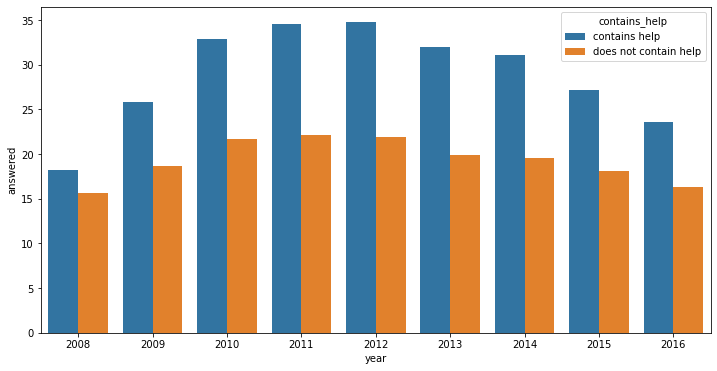

In [5]:
f = plt.figure(figsize=(12, 6))
ax = sns.barplot(x="year", y="answered", hue="contains_help", data=df)

It turns out that in 2016, 23.5% of post containing the word  "help” got an accepted answer versus only only 16% of questions that didn't have 'help”. And this pattern remains consistent if you look back through the years.

So if you want people to actually answer your Stack Overflow questions, ask the question with help word. 

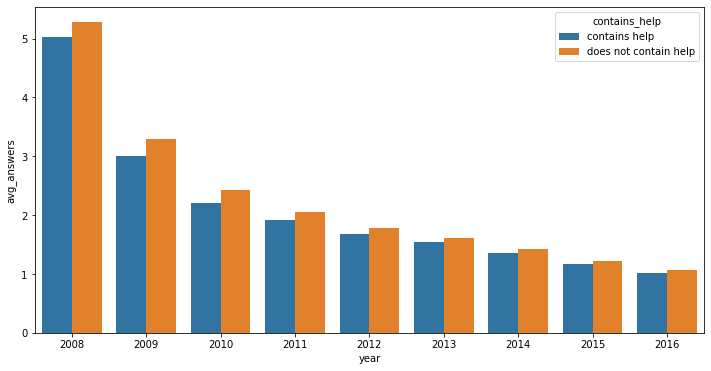

In [8]:
f = plt.figure(figsize=(12, 6))
ax = sns.barplot(x="year", y="avg_answers", hue="contains_help", data=df)

### **References**


1.   [Felipe Hoffa](https://hoffa.medium.com/)
2. https://www.stratascratch.com/blog/the-ultimate-guide-to-sql-window-functions/
2.https://medium.com/parse-ly-engineering/what-are-the-most-confusing-software-development-topics-df7ef1d72845


